In [12]:
import numpy as np
import matplotlib.pyplot as plt

# ====== INPUT PARAMETERS ======
# Ring geometry (in mm)
# outer_diameter
# inner_diameter
# height
# Residual induction (Tesla)
# ====== CONSTANTS ======
mu0 = 4 * np.pi * 1e-7  # H/m (magnetic constant)
h = 6.62607015e-34 #SI unit
g = 2.002319
uB = 9.2740100657e-24

y0 = -2.132761e-6        #typical values from ODMR experiment
sigma = 6.376516e5
hf = 2.207467e6
D = 2.878042e+09
a = 1e-5

class Bar_magnet:
    '''
    SI units
    '''
    Length: float
    Width: float
    Thickness: float
    Distance : float
    Mx : float
    My : float
    Mz : float
    def __init__(self, Length, Width, Distance, Thickness, My, Mx = 0, Mz = 0):
        self.Length = Length
        self.Width = Width
        self.Thickness = Thickness
        self.Distance = Distance
        self.Mx = Mx
        self.My = My
        self.Mz = Mz

class Ring_magnet:
    R_in : float
    R_out: float
    H : float
    Mx : float
    My : float
    Mz : float
    z : float
    def __init__(self, R_in, R_out, H, Mz, Mx = 0, My = 0, z = 0):
        self.R_in = R_in
        self.R_out = R_out
        self.H = H
        self.Mx = Mx
        self.My = My
        self.Mz = Mz
        self.z = z

def mm2m(x):
    """
    Helper function: convert mm to meters
    """
    return x * 1e-3

def dipole(r_vec:np.array, m_vec:np.array):
  """
  Input: r_vec: seperation vector
         m_vec: magnetic dipole of one segment
  Output: Magnetic field generated by the dipole at the observation point
  """
  # Magnetic dipole field formula:
  # B = μ0/(4π) * [3(m·r̂)r̂ - m] / r^3
  r_mag = np.linalg.norm(r_vec)
  if r_mag < 1e-9:
    return np.array([0,0,0])  # Skip self-contribution
  else:
    r_hat = r_vec / r_mag
    m_dot_rhat = np.dot(m_vec, r_hat)
    B_vec = (mu0 / (4*np.pi)) * (3 * m_dot_rhat * r_hat - m_vec) / (r_mag**3)
    return B_vec

# ====== FUNCTION TO COMPUTE FIELD AT A POINT ======
def field_ring(magnet:Ring_magnet, r_obs, z_obs, n_r=40, n_phi=120, n_z=10, fi = 0):
    """
    Compute the magnetic field from an axially magnetized ring at a given point.
    The center of the ring magnet is assumed to be at the origin (x, y, z) = (0, 0, Ring_magnet.z).

    Parameters:
        r_obs, z_obs, fi : observation point coordinates in meters and radians
        n_r, n_phi, n_z : discretization steps in r, phi, z for numerical integration
        Dimension of the ring magnet:
          Mz, Mx, My : magnetization in z, x, y directions (H/m)
          R_in, R_out : inner and outer radius of the ring magnet (m)
          H : thickness of the ring magnet (m)
    Returns:
        (B_x, B_y, Bz) : x, y, z components of B (Tesla)
    """
    R_in = magnet.R_in
    R_out = magnet.R_out
    H = magnet.H
    Mx = magnet.Mx
    My = magnet.My
    Mz = magnet.Mz
    z_height = magnet.z
    # Discretize the ring volume
    r_vals = np.linspace(R_in, R_out, n_r)
    phi_vals = np.linspace(0, 2*np.pi, n_phi, endpoint=False)
    z_vals = np.linspace(-H/2 + z_height, H/2 + z_height, n_z)

    # Volume element sizes
    dr = (R_out - R_in) / (n_r - 1)
    dphi = 2*np.pi / n_phi
    dz = H / (n_z - 1)

    Bz_total = 0.0
    Bx_total = 0.0
    By_total = 0.0
    for r in r_vals:
        for phi in phi_vals:
            for z in z_vals:
                # Source element coordinates
                x_src = r * np.cos(phi)
                y_src = r * np.sin(phi)
                z_src = z

                # Vector from source to observation point
                dx = r_obs * np.cos(fi) - x_src
                dy = r_obs * np.sin(fi) - y_src
                dzv = z_obs - z_src

                r_vec = np.array([dx, dy, dzv])
                # r_mag = np.linalg.norm(r_vec)

                # if r_mag < 1e-9:
                #     continue  # Skip self-contribution

                # Volume of the element
                dV = r * dr * dphi * dz

                # Magnetic moment of the element (aligned along z-axis)
                m_vec = np.array([Mx * dV, My * dV, Mz * dV])

                # Magnetic dipole field formula:
                # B = μ0/(4π) * [3(m·r̂)r̂ - m] / r^3
                # r_hat = r_vec / r_mag
                # m_dot_rhat = np.dot(m_vec, r_hat)
                # B_vec = (mu0 / (4*np.pi)) * (3 * m_dot_rhat * r_hat - m_vec) / (r_mag**3)
                B_vec = dipole(r_vec, m_vec)

                Bz_total += B_vec[2]
                Bx_total += B_vec[0]
                By_total += B_vec[1]
    return Bx_total, By_total, Bz_total

def field_bar(magnet:Bar_magnet, x_obs, y_obs, z_obs, n_x=60, n_y=20, n_z=40):
    """
    Compute the magnetic field from an axially magnetized ring at a given point.
    The center of the two parallel bar magnets is at the origin (x, y, z) = (0, 0, 0).

    Parameters:
        x_obs, y_obs, z_obs : observation point coordinates (m)
        n_x, n_y, n_z : discretization steps in x, y, z for numerical integration
        Dimension of the bar magnet:
          Mz, Mx, My : magnetization in z, x, y directions (H/m)
          Length, Width, Thickness of the bar magnet (m)
    Returns:
        (B_x, B_y, Bz) : x, y, z components of B (Tesla)
    """
    Length = magnet.Length
    Width = magnet.Width
    Thickness = magnet.Thickness
    Distance = magnet.Distance
    Mx = magnet.Mx
    My = magnet.My
    Mz = magnet.Mz
    x_vals = np.linspace(-Length/2, Length/2, n_x)
    y_vals = np.concat((np.linspace(-Distance/2 - Thickness, -Distance/2, n_y), np.linspace(Distance/2, Distance/2 + Thickness, n_y)))
    z_vals = np.linspace(-Width/2, Width/2, n_z)
    # Volume element sizes
    Dx = Length / (n_x - 1)
    Dy = Thickness / (n_y - 1)
    Dz = Width / (n_z - 1)
    Bz_total = 0.0
    Bx_total = 0.0
    By_total = 0.0
    dV = Dx * Dy * Dz
    for x in x_vals:
        for y in y_vals:
            for z in z_vals:
                dx = x_obs - x
                dy = y_obs - y
                dz = z_obs - z
                r_vec = np.array([dx, dy, dz])
                m_vec = np.array([Mx * dV, My * dV, Mz * dV])
                B_vec = dipole(r_vec, m_vec)
                Bx_total += B_vec[0]
                By_total += B_vec[1]
                Bz_total += B_vec[2]
    return Bx_total, By_total, Bz_total

# ====== Table display ======

def table_display(magnet:Ring_magnet, radial_offset, z_values):
  """
  Table display of magnetic field distribution at different height z
  radial_offset: radial offset from the axis for comparison (mm)
  z_values: array of axial distances from the bottom of magnet (mm)
  """
  print(f"{'z (mm)':>7} | {'Bx_axis (mT)':>12} | {f'B_x={radial_offset}mm (mT)':>14} | {'By_axis (mT)':>12}  |{f'B_y={radial_offset}mm (mT)':>14} |  {'Bz_axis (mT)':>12} |{f'B_z={radial_offset}mm (mT)':>14} |  {'|ΔB_x| (µT)':>10}  |  {'|ΔB_y| (µT)':>10}  |  {'|ΔB_z| (µT)':>10}  |  {'|ΔB| (µT)':>10}")
  for z_mm in z_values:
      # Field on the axis
      Bx_axis, By_axis, Bz_axis = field_ring(magnet, 0.0, mm2m(z_mm))
      # Field at radial offset
      Bx_off, By_off, Bz_off = field_ring(mm2m(radial_offset), mm2m(z_mm))
      # Convert to mT for printing
      Bz_axis_mT = Bz_axis * 1e3
      Bz_off_mT = Bz_off * 1e3
      Bx_axis_mT = Bx_axis * 1e3
      Bx_off_mT = Bx_off * 1e3
      By_axis_mT = By_axis * 1e3
      By_off_mT = By_off * 1e3
      # Absolute difference in µT
      deltaz_uT = abs(Bz_axis_mT - Bz_off_mT) * 1e3
      deltax_uT = abs(Bx_axis_mT - Bx_off_mT) * 1e3
      deltay_uT = abs(By_axis_mT - By_off_mT) * 1e3
      delta_uT = np.sqrt(deltax_uT**2 + deltay_uT**2 + deltaz_uT**2)
      # Relative difference in ppm
      #delta_ppm = delta_uT / (B_axis_mT * 1e3) * 1e6

      print(f"{z_mm:7.1f} | {Bx_axis_mT:12.4f} | {Bx_off_mT:14.4f} |  {By_axis_mT:12.4f} | {By_off_mT:14.4f}| {Bz_axis_mT:12.4f}  | {Bz_off_mT:14.4f}| {deltax_uT:10.2f}    |{deltay_uT:10.2f}     |{deltaz_uT:10.2f}     |{delta_uT:10.2f} ")


def vector_transf(Bx, By, Bz, yangle, xangle):
  """
  Transform B vector from the frame of ring magnet to that of sample plate
  """
  yangle = -yangle
  xangle = -xangle
  B = np.array([Bx, By, Bz])
  rot_matrix_y = np.array([[np.cos(yangle), 0, -np.sin(yangle)],
                [0, 1, 0],
                [np.sin(yangle), 0, np.cos(yangle)]])
  rot_matrix_x = np.array([[1, 0, 0],
                [0, np.cos(xangle), -np.sin(xangle)],
                [0, np.sin(xangle), np.cos(xangle)]])
  rot = np.matmul(rot_matrix_x, rot_matrix_y)
  B_new = np.matmul(rot, B)
  return B_new[0], B_new[1], B_new[2]

def azimuthal_angle(x,y):
  """
  Compute azimuthal angle
  Input: x, y
  Output: fi in radians
  """
  if x > 0 and y >= 0:
    fi = np.arctan(y/x)
  elif x == 0 and y > 0:
    fi = np.pi/2
  elif x == 0 and y < 0:
    fi = -np.pi/2
  elif x < 0 and y >= 0:
    fi = np.arctan(y/x) + np.pi
  elif x < 0 and y < 0:
    fi = np.arctan(y/x) + np.pi
  elif x > 0 and y < 0:
    fi = np.arctan(y/x)
  else:
    fi = 0
  return fi

def rotation(x, y, z, yangle, xangle):
  """
  rotate matrix point by yangle and xangle
  Input: position x, y, z and angles yangle, xangle
  Output: position in cylindrical coordinate system (r, z, fi) ## fi in radians
  """
  position = np.array([x,y,0])
  rotation_y = np.array([[np.cos(yangle), 0, -np.sin(yangle)],
                [0, 1, 0],
                [np.sin(yangle), 0, np.cos(yangle)]])

  rotation_x = np.array([[1, 0, 0],
                [0, np.cos(xangle), -np.sin(xangle)],
                [0, np.sin(xangle), np.cos(xangle)]])
  rotation = np.matmul(rotation_x , rotation_y)
  position_new = np.matmul(rotation, position)
  position_new[2] += z
  r = np.sqrt(position_new[0]**2 + position_new[1]**2)
  x_new, y_new = position_new[0], position_new[1]
  fi = azimuthal_angle(x_new, y_new)
  return r, position_new[2], fi

def rotation_cartesian(x, y, z, yangle, xangle):
  """
  rotate matrix point by yangle and xangle
  Input: position x, y, z and angles yangle, xangle
  Output: position in cylindrical coordinate system (r, z, fi) ## fi in radians
  """
  position = np.array([x,y,0])
  rotation_y = np.array([[np.cos(yangle), 0, -np.sin(yangle)],
                [0, 1, 0],
                [np.sin(yangle), 0, np.cos(yangle)]])

  rotation_x = np.array([[1, 0, 0],
                [0, np.cos(xangle), -np.sin(xangle)],
                [0, np.sin(xangle), np.cos(xangle)]])
  rotation = np.matmul(rotation_x , rotation_y)
  position_new = np.matmul(rotation, position)
  position_new[2] += z
  return position_new

def magnetic_profile(magnet:Ring_magnet, z_mm, yangle = 0, xangle = 0):
  """
  Magnetic field profile, or magnetic field at each matrix point, at a given z-coordinate.
  Parameters: Dimensions and magnetization of the magnet R_in, R_out, H, Mx, My, Mz
  z_mm is the height of the center of the sample, yangle is the rotation angle of the sample around y axis, and xangle is the rotation angle of the sample around x axis
  The sample is assumed to be parallel to y axis and angle 0 by default.
  Output: three matrices (matrix_B_x, matrix_B_y, matrix_B_z), where the first index corresponds to x index and the second to the y index. Magnetic field are in the rotated frame.
  """
  matrix_B_x = np.zeros((5,5),float)
  matrix_B_y = np.zeros((5,5),float)
  matrix_B_z = np.zeros((5,5),float)
  position_el = np.linspace(-0.8,0.8,5)  #mm
  if isinstance(magnet, Ring_magnet):
    for i in range(5):
      for j in range(5):
        r, z, fi = rotation(position_el[i], position_el[j], z_mm, yangle = yangle, xangle = xangle)
        Bx_axis, By_axis, Bz_axis = field_ring(magnet, mm2m(r), mm2m(z), fi = fi)
        matrix_B_x[i][j], matrix_B_y[i][j], matrix_B_z[i][j] = vector_transf(Bx_axis, By_axis, Bz_axis, yangle, xangle)

    return matrix_B_x, matrix_B_y, matrix_B_z
  if isinstance(magnet, Bar_magnet):
    for i in range(5):
      for j in range(5):
        x, y, z = rotation_cartesian(position_el[i], position_el[j], z_mm, yangle = yangle, xangle = xangle)
        Bx_axis, By_axis, Bz_axis = field_bar(magnet, mm2m(x), mm2m(y), mm2m(z))
        matrix_B_x[i][j], matrix_B_y[i][j], matrix_B_z[i][j] = vector_transf(Bx_axis, By_axis, Bz_axis, yangle, xangle)

    return matrix_B_x, matrix_B_y, matrix_B_z
  else:
    print("invalid input")


def magnetic_profile_point(magnet:Ring_magnet, x_mm, y_mm, z_mm, yangle = 0, xangle = 0):
  """
  Magnetic field profile of a signgle point, at a given z-coordinate.
  parameters: z_mm is the height of the center of the sample, yangle is the rotation angle of the sample around y axis, and xangle is the rotation angle of the sample around x axis
  The sample is assumed to be parallel to y axis and angle 0 by default.
  """
  if isinstance(magnet, Ring_magnet):
    r, z, fi = rotation(x_mm, y_mm, z_mm, yangle = yangle, xangle = xangle)
    Bx_0, By_0, Bz_0 = field_ring(magnet, mm2m(r), mm2m(z), fi = fi)
    B_x, B_y, B_z = vector_transf(Bx_0, By_0, Bz_0, yangle, xangle)

    return B_x, B_y, B_z
  if isinstance(magnet, Bar_magnet):
    x, y, z = rotation_cartesian(x_mm, y_mm, z_mm, yangle = yangle, xangle = xangle)
    Bx_0, By_0, Bz_0 = field_bar(magnet, mm2m(x), mm2m(y), mm2m(z))
    B_x, B_y, B_z = vector_transf(Bx_0, By_0, Bz_0, yangle, xangle)
    return B_x, B_y, B_z

def gauss_33(x,x0,a):
  y = y0 - a*np.exp(-(x-x0)**2/(2*sigma**2))-a*np.exp(-(x-x0-hf)**2/(2*sigma**2))-a*np.exp(-(x-x0+hf)**2/(2*sigma**2))
  return y
def y(x,peaks:np.array):         # simulated spectrum
  y = 0
  for i in range(peaks.shape[1]):
    y += gauss_33(x,peaks[0,i],peaks[1,i])
  return y
def ODMR_sim(Bx,By,Bz):
  num_peaks = 8
  peaks = np.zeros((2,num_peaks))
  df = np.zeros(4)
  B = np.sqrt(Bx**2 + By**2+ Bz**2)
  theta = np.arccos(Bz/B)
  B_rho = np.sqrt(Bx**2 + By**2)
  phi = azimuthal_angle(Bx, By)
  df[0] = abs((1/h)*2*g*uB* (B * np.sin(theta) * (np.cos(phi) + np.sin(phi)) + B * np.cos(theta)))
  df[1] = abs((1/h)*2*g*uB* (B * np.sin(theta) * (np.cos(phi) - np.sin(phi)) - B * np.cos(theta)))
  df[2] = abs((1/h)*2*g*uB* (B * np.sin(theta) * (np.sin(phi) - np.cos(phi)) - B * np.cos(theta)))
  df[3] = abs((1/h)*2*g*uB* (-B * np.sin(theta) * (np.cos(phi) + np.sin(phi)) + B * np.cos(theta)))
  for i in range(4):
    peaks[0][i] = D - df[i]/2
    peaks[0][num_peaks-1-i] = D + df[i]/2
    peaks[1][i] = a
    peaks[1][num_peaks-1-i] = a
  return peaks


In [68]:
# Magnetization properties
Br = 1.26     # Residual induction of NdFeB magnets
mu0 = 4 * np.pi * 1e-7  # H/m (magnetic constant)
Mz = Br / mu0
# Dimension of the ring magnet in mm
outer_diameter = 63.5
inner_diameter = 12.0
height = 10.0
distance = 115 #distance between the two magnets

R_out = mm2m(outer_diameter / 2)
R_in = mm2m(inner_diameter / 2)
H = mm2m(height)
z = mm2m(height/2 + distance/2)
ring_magnet_1 = Ring_magnet(R_in, R_out, H, Mz, z = z)
ring_magnet_2 = Ring_magnet(R_in, R_out, H, Mz, z = -z)
#Observation point
z_mm = 0          #height of the sample
yangle = 0 * np.pi/180          #pitch angle of the sample
xangle = 0 * np.pi/180

B_x, B_y, B_z = magnetic_profile_point(ring_magnet_1, 0, 0, z_mm, yangle = yangle, xangle = xangle)
B_x1, B_y1, B_z1 = magnetic_profile_point(ring_magnet_2, 0, 0,z_mm, yangle = yangle, xangle = xangle)
B_z += B_z1
print(f'Distance = {distance} mm \nB_z = {B_z*1e3:.3f} mT')

Distance = 115 mm 
B_z = 40.090 mT


In [71]:
position_el = np.linspace(-0.8,0.8,5)
matrix_B_x = np.zeros((5,5),float)
matrix_B_y = np.zeros((5,5),float)
matrix_B_z = np.zeros((5,5),float)
y = 0
for i in range(5):
  for j in range(5):
    x = position_el[i]
    z = position_el[j]
    result_1 =  magnetic_profile_point(ring_magnet_1, x, y, z)
    result_2 = magnetic_profile_point(ring_magnet_2, x, y, z)
    matrix_B_x[i,j] = result_1[0] + result_2[0]
    matrix_B_y[i,j] = result_1[1] + result_2[1]
    matrix_B_z[i,j] = result_1[2] + result_2[2]
    # matrix_B_y[i,j], matrix_B_z[i,j] = magnetic_profile_point(ring_magnet_1, x, y, z)
    #matrix_B_x[i,j], matrix_B_y[i,j], matrix_B_z[i,j] += magnetic_profile_point(ring_magnet_2, x, y, z)[]
     #+ magnetic_profile_point(ring_magnet_2, x, y, z)

Distance = 115 mm


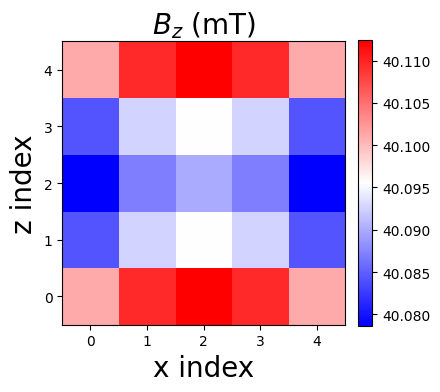

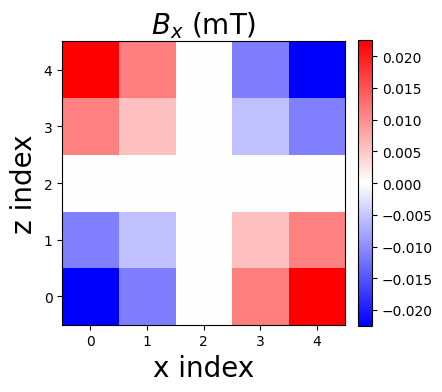

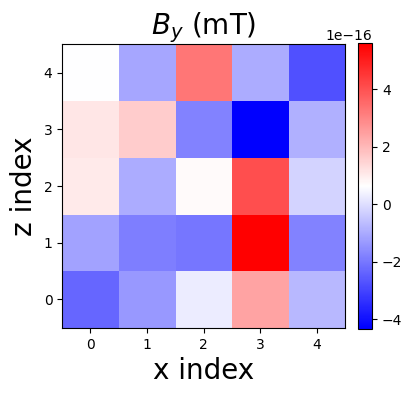

In [73]:
print(f'Distance = {distance} mm')
plt.figure(figsize=(4,4))
im1 = plt.imshow(matrix_B_z.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('z index',size = 20)
plt.title(f'$B_z$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im2 = plt.imshow(matrix_B_x.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('z index',size = 20)
plt.title(f'$B_x$ (mT)',size = 20)
plt.show()
plt.figure(figsize=(4,4))
im3 = plt.imshow(matrix_B_y.T*1e3, origin = 'lower', cmap = 'bwr')
plt.colorbar(im3,fraction=0.046, pad=0.04)
plt.xlabel('x index',size = 20)
plt.ylabel('z index',size = 20)
plt.title(f'$B_y$ (mT)',size = 20)
plt.show()
